# WindEye

Use computer vision to identify and analyze wind turbines in satellite imagery.
Part of the GBDX 2018 entry by the World Resources Institute (WRI) and Duke University.
1. Import manually assembled lat/long coordinates for sites with and without wind turbines around the globe.
2. Order imagery clips from WorldView 2 for these locations, grayscale, and resize to standard shape (64x64 pixels).
3. Extract HOG features from images.
4. Train a binary classifier on these HOG features.
5. Deploy the classifier in a new geography to find wind turbines.
6. Deploy the classifier in historical imagery at turbine locations to identify construction date.
7. Train a convolutional neural network (CNN) on images.
8. Repeat steps above with CNN.


In [31]:
# import what we need

import numpy as np
import matplotlib.pyplot as plt
import pickle
import requests
import csv
from random import shuffle
from skimage.transform import resize
from skimage import data, color, feature, exposure
from shapely.geometry import box
from gbdxtools import CatalogImage, Interface
gbdx = Interface()

%matplotlib inline

WIND_TURBINE_COORDINATES = 'wind_turbine_coordinates_all.csv'
NOT_WIND_TURBINE_COORDINATES = 'not_wind_turbine_coordinates_all.csv'
WIND_TURBINE_PICKLE = 'wind_turbine_images.p'
NOT_WIND_TURBINE_PICKLE = 'not_wind_turbine_images.p'
IM_SIZE = 64   # pixels per side for analyzed images

In [2]:
# download coordinates files
url1 = "https://github.com/colinmccormick/WindEye/raw/master/wind_turbine_coordinates_all.csv"
url2 = "https://github.com/colinmccormick/WindEye/raw/master/not_wind_turbine_coordinates_all.csv"
r1 = requests.get(url1,allow_redirects=True)
r2 = requests.get(url2,allow_redirects=True)
open(WIND_TURBINE_COORDINATES,'w').write(r1.content)
open(NOT_WIND_TURBINE_COORDINATES,'w').write(r2.content)
!ls

Active_Fire_Detection_using_SWIR_Imagery.ipynb
Advanced_Band_Math_Tutorial_Using_SWIR_Imagery_for_Creating_Spectral_Indices.ipynb
Advanced_Imagery_Access.ipynb
Algorithm_Prototyping_Coastline_Extraction.ipynb
Beginner_Band_Math_for_Remote_Sensing_Spectral_Indices.ipynb
Detecting_Change_Over_Time.ipynb
Detecting_Tents_in_the_Dabaab_Kenya_Refugee_Camp.ipynb
Image_Classification_Part_1_Building_a_Simple_Image_Classifier.ipynb
Imagery_and_AOIs.ipynb
Imagery_test_01.ipynb
Imagery_test_02.ipynb
Introduction_to_GBDX_notebooks.ipynb
Ordering_and_Working_with_Imagery.ipynb
WindEye_v01.ipynb
not_wind_turbine_coordinates_all.csv
not_wind_turbine_images.p
output.bak
output.dat
output.dir
ports.json
wind_turbine_coordinates_all.csv
wind_turbine_images.p


In [3]:
# define utility functions

def make_bbox(coords,box_side_meters=150):
    # define a bbox of specified side length centered on coords
    # should probably upgrade this with haversine function
    latitude,longitude = coords
    assert latitude >=-90 and latitude <= 90, u"Error with latitude"
    assert longitude >=-180 and longitude <= 180, u"Error with longitude"
    earth_circumference_meters = 40000000
    d_lat = 0.5 * 360 * box_side_meters / earth_circumference_meters
    #d_long = d_lat / np.cos(2 * np.pi * latitude / 360) 
    d_long = d_lat
    return [longitude-d_long,latitude-d_lat,longitude+d_long,latitude+d_lat]
    
def search_unordered(bbox, _type=None, count=100, cloud_cover=10):
    # search for available imagery in bbox
    aoi = box(*bbox).wkt
    if _type:
        query = "item_type:{} AND item_type:DigitalGlobeAcquisition".format(_type)
    else:
        query = "item_type:DigitalGlobeAcquisition"
    query += " AND attributes.cloudCover_int:<{}".format(cloud_cover)
    return gbdx.vectors.query(aoi, query, count=count)

def order(img_id):
    # order imagery
    order = gbdx.Task("Auto_Ordering", cat_id=img_id)
    order.impersonation_allowed = True
    wf = gbdx.Workflow([order])
    wf.execute()
    return wf

In [4]:
# read turbine and non-turbine coordinates
# order: latitude,longitude

turbine_locations = []
with open(WIND_TURBINE_COORDINATES,'r') as f:
    datareader = csv.reader(f)
    header = next(datareader)
    for row in datareader:
        latitude = float(row[0])
        longitude = float(row[1])
        country = row[2]    # for future use
        turbine_locations.append([latitude,longitude])
print(u"Read {0} wind turbine locations.".format(len(turbine_locations)))
        
not_turbine_locations = []
with open(NOT_WIND_TURBINE_COORDINATES,'r') as f:
    datareader = csv.reader(f)
    header = next(datareader)
    for row in datareader:
        latitude = float(row[0])
        longitude = float(row[1])
        country = row[2]    # for future use
        not_turbine_locations.append([latitude,longitude])
print(u"Read {0} not wind turbine locations.".format(len(not_turbine_locations)))
  
# combine location lists and randomize
all_locations = zip(np.ones(len(turbine_locations)),turbine_locations) \
                + zip(np.zeros(len(not_turbine_locations)),not_turbine_locations) 
shuffle(all_locations)


Read 1197 wind turbine locations.
Read 1129 not wind turbine locations.


In [5]:
# set up tracking of images ordered
wfs = []
catalog_ids = []

In [6]:
# search for imagery at known turbine and not-turbine locations
# limit search to specific sensor platform for consistency
# order most chronologically recent image

location_data = []
#sensor_plaform = u"SENTINEL2"
#sensor_platform = u"WV03"
sensor_platform = u"WV02"
for loc_info in all_locations[0:64]:
    is_turbine = loc_info[0]
    loc = loc_info[1]
    bbox = make_bbox(loc)
    records = search_unordered(bbox,_type=sensor_platform)
    try:
        r = records[0]   # assumes most recent image first - should confirm
    except:
        print(u"No images for coordinates: {0}, skipping.".format(loc))
        continue
    cat_id = r['properties']['attributes']['catalogID']
    date = r['properties']['item_date']
    sensor = r['properties']['attributes']['sensorPlatformName']
    print(u"{0}: {1} ({2}) is from {3}.".format(loc,cat_id,sensor,date))
    location_data.append({'coordinates':loc,'bbox':bbox,'catalog_id':cat_id,'date':date,'sensor':sensor,'is_turbine':is_turbine})
    if cat_id not in catalog_ids:
        catalog_ids.append(cat_id)
        print(u"Ordering catalog ID {0}".format(cat_id))
        wfs.append(order(cat_id))

print(u"Ordered {0} images.".format(len(wfs)))


[34.989117, 135.583649]: 10300100633B4900 (WORLDVIEW02) is from 2017-01-26T01:43:45.410Z.
Ordering catalog ID 10300100633B4900
[48.086924, 16.260431]: 1030010071351D00 (WORLDVIEW02) is from 2017-09-08T09:58:32.000Z.
Ordering catalog ID 1030010071351D00
[36.563057, 129.246291]: 103001001F7ECA00 (WORLDVIEW02) is from 2013-02-15T02:25:00.683Z.
Ordering catalog ID 103001001F7ECA00
[10.617576, 122.704008]: 1030010048D42600 (WORLDVIEW02) is from 2015-08-29T02:23:54.626Z.
Ordering catalog ID 1030010048D42600
[34.983245, -118.816366]: 10300100790DFE00 (WORLDVIEW02) is from 2018-02-20T18:56:24.000Z.
Ordering catalog ID 10300100790DFE00
[41.87596, -4.784878]: 103001006B6EFA00 (WORLDVIEW02) is from 2017-07-21T11:44:44.000Z.
Ordering catalog ID 103001006B6EFA00
[-34.100078, -56.08808]: 103001007B536E00 (WORLDVIEW02) is from 2018-02-07T13:54:33.000Z.
Ordering catalog ID 103001007B536E00
[48.185846, 16.11203]: 103001006F4DA100 (WORLDVIEW02) is from 2017-08-25T10:14:46.612Z.
Ordering catalog ID 10300

In [11]:
# monitor delivery of ordered imagery

complete = 0
for w in wfs:
    complete += 1 if w.status['state'] == u'complete' else 0
print(u"Complete: {0} / {1}".format(complete, len(wfs)))

Complete: 39 / 41


In [18]:
# get image chips and adjust for analysis

turbine_images = []
not_turbine_images = []
for loc_data in location_data[0:32]:
    cat_id = loc_data['catalog_id']
    bbox = loc_data['bbox']
    sensor = loc_data['sensor']
    try:
        print(u"Trying to get chip from image {0}...".format(cat_id))
        im = CatalogImage(cat_id, band_type="MS", bbox=bbox)
        im_prepared = resize(rgb2gray(im.rgb()),(IM_SIZE,IM_SIZE))
        if loc_data['is_turbine']:
            turbine_images.append(im_prepared)
        else:
            not_turbine_images.append(im_prepared)
    except:
        print(u"Error with {0}".format(cat_id))
        continue

print(u"Prepared {0} tubine images, {1} not-turbine images.".format(len(turbine_images),len(not_turbine_images)))
        
# pickle resulting images

with open(WIND_TURBINE_PICKLE,'w') as f:
    pickle.dump(turbine_images,f)
with open(NOT_WIND_TURBINE_PICKLE,'w') as f:
    pickle.dump(not_turbine_images,f)

Trying to get chip from image 10300100633B4900...
Got im, resizing...
Fetching Image... 1 tile
Resized, saving...
Trying to get chip from image 1030010071351D00...
Got im, resizing...
Fetching Image... 1 tile
Resized, saving...
Trying to get chip from image 103001001F7ECA00...
Got im, resizing...
Fetching Image... 1 tile
Resized, saving...
Trying to get chip from image 1030010048D42600...
Error with 1030010048D42600
Trying to get chip from image 10300100790DFE00...
Got im, resizing...
Fetching Image... 1 tile
Resized, saving...
Trying to get chip from image 103001006B6EFA00...
Got im, resizing...
Fetching Image... 1 tile
Resized, saving...
Trying to get chip from image 103001007B536E00...
Got im, resizing...
Fetching Image... 1 tile
Resized, saving...
Trying to get chip from image 103001006F4DA100...
Got im, resizing...
Fetching Image... 1 tile
Resized, saving...
Trying to get chip from image 10300100248F8800...
Got im, resizing...
Fetching Image... 1 tile
Resized, saving...
Trying to 

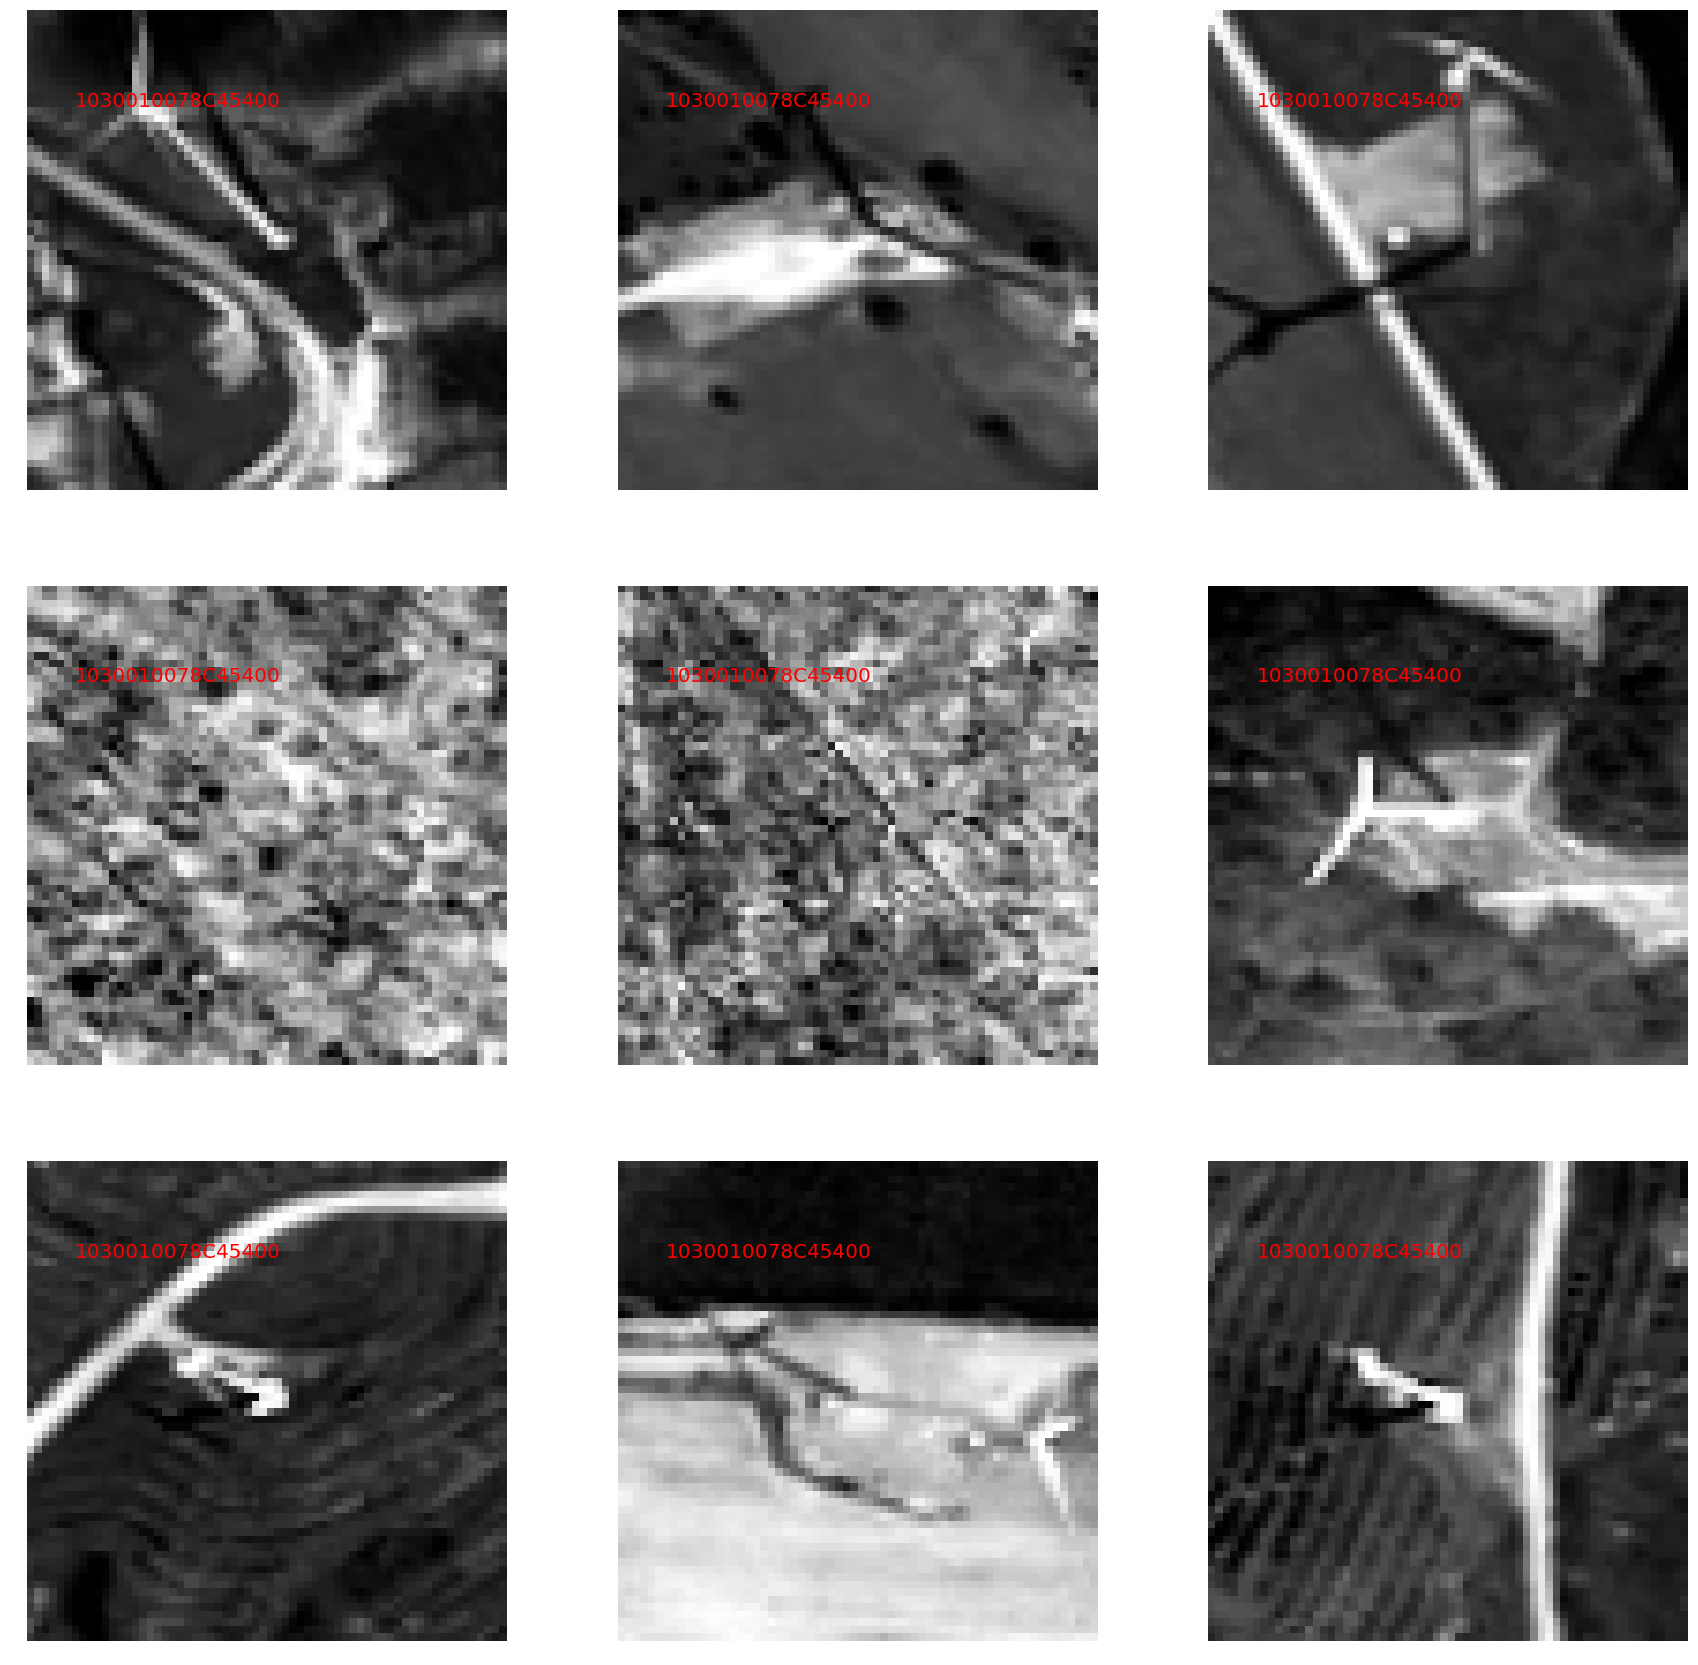

In [25]:
# display sample turbine images

f1 = plt.figure(figsize=(30,30))
plots_per_side = 3
count = 1
for im in turbine_images:
    ax = f1.add_subplot(plots_per_side,plots_per_side,count)
    ax.axis('off')
    ax.imshow(im,cmap="gray")
    #ax.text(0.1,0.8,"{0}".format(cat_id),color='r',fontsize=20,transform=ax.transAxes)
    if count >= plots_per_side ** 2:
        break
    count += 1
plt.show()


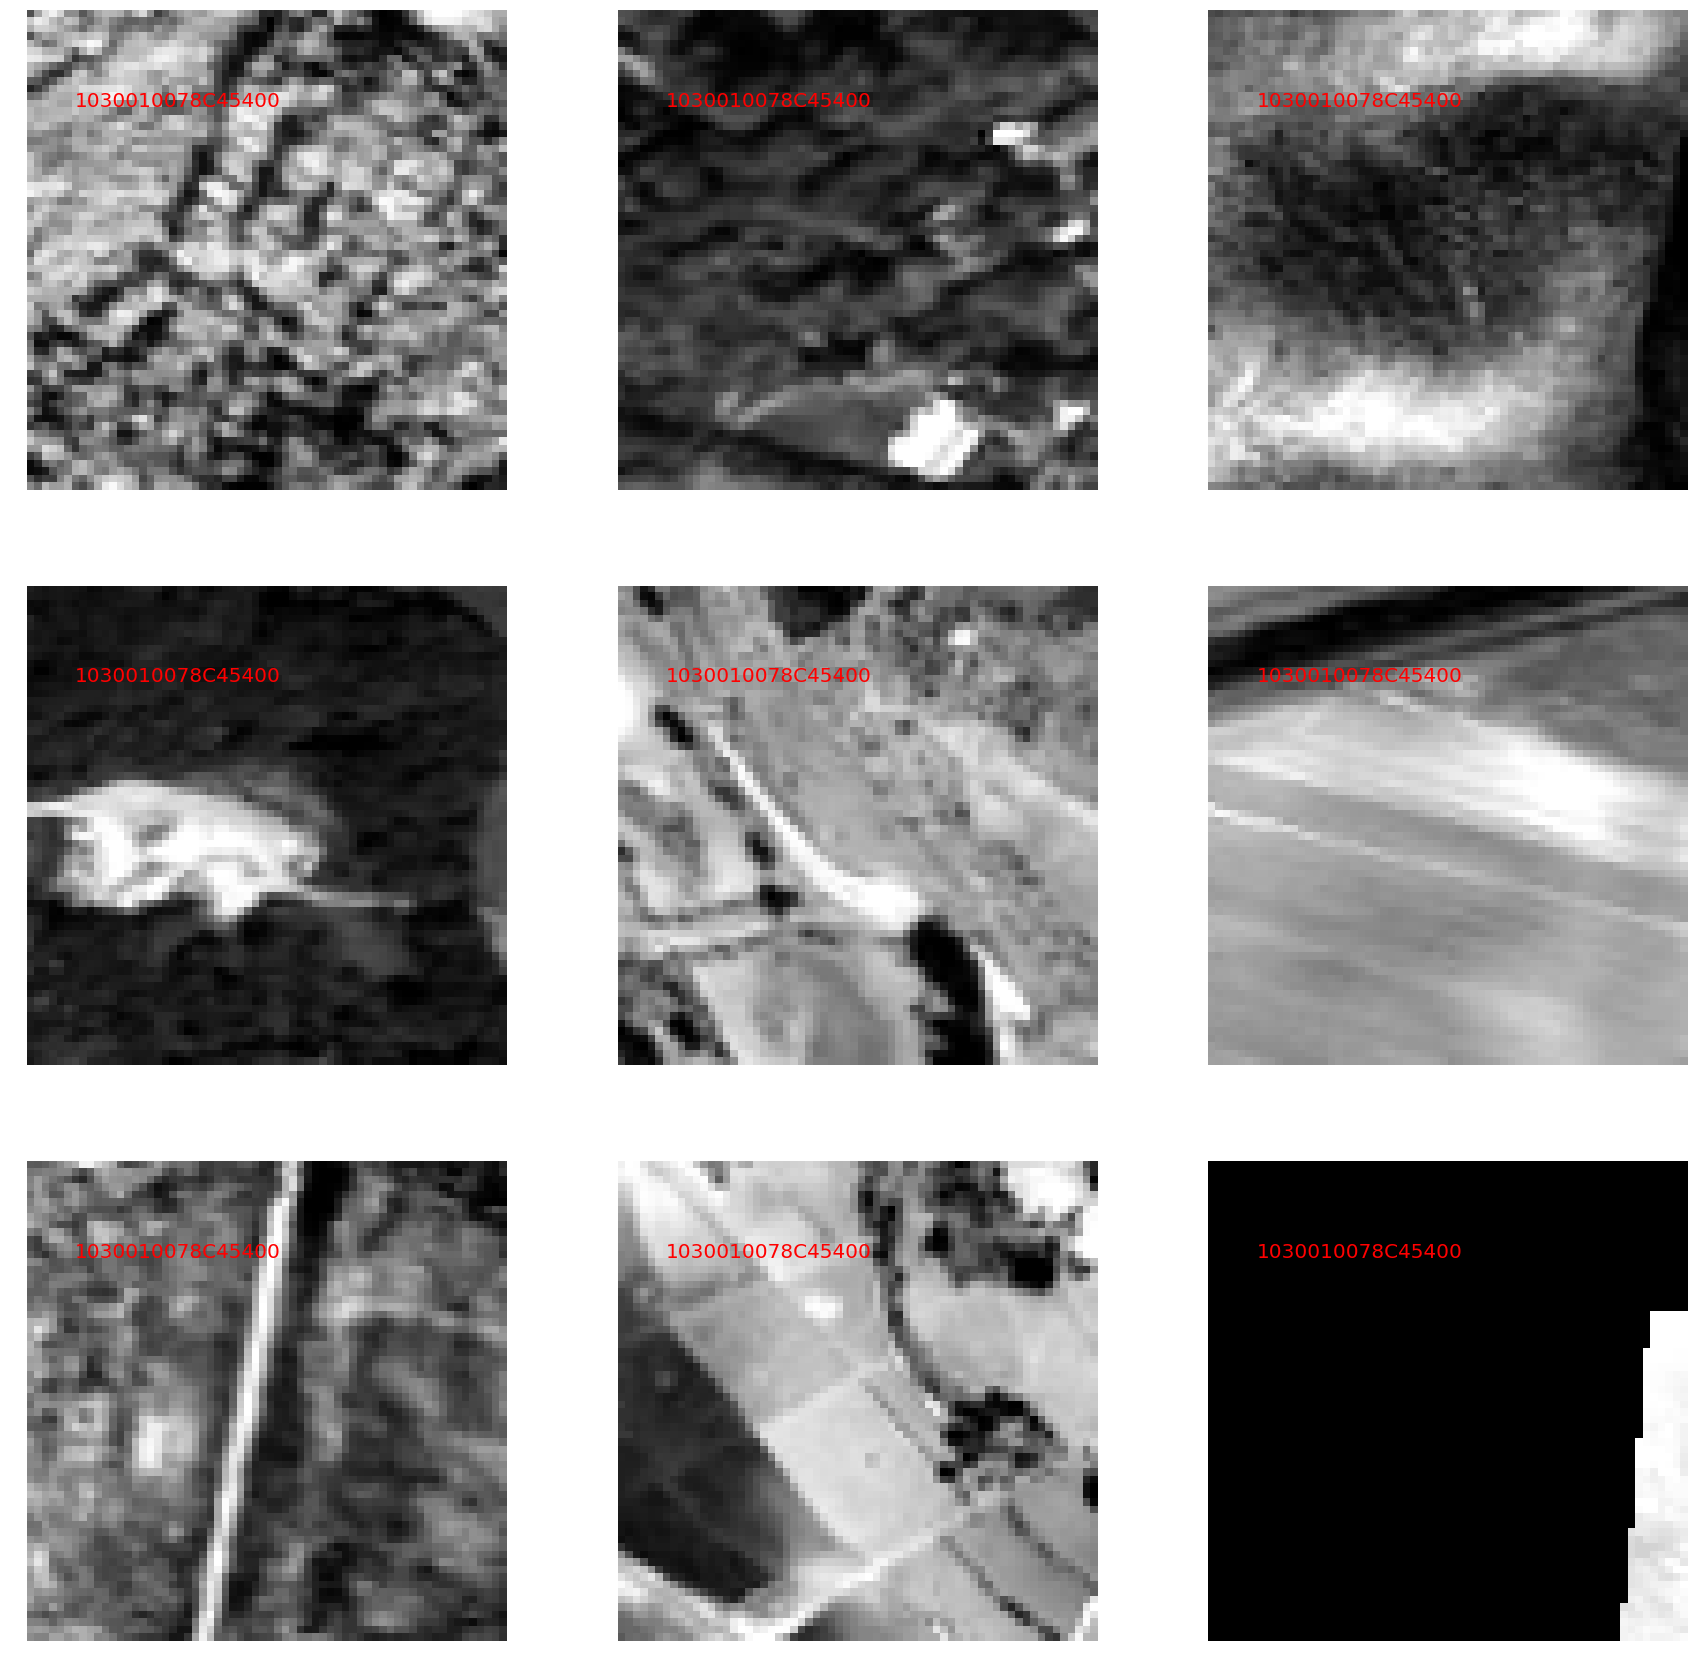

In [26]:
# display sample not-turbine images

f2 = plt.figure(figsize=(30,30))
plots_per_side = 3
count = 1
for im in not_turbine_images:
    ax = f2.add_subplot(plots_per_side,plots_per_side,count)
    ax.axis('off')
    ax.imshow(im,cmap="gray")
    #ax.text(0.1,0.8,"{0}".format(cat_id),color='r',fontsize=20,transform=ax.transAxes)
    if count >= plots_per_side ** 2:
        break
    count += 1
plt.show()

In [27]:
# upgrade pip and install sklearn

!pip install --upgrade pip
!pip install sklearn

  Using cached pip-9.0.3-py2.py3-none-any.whl
  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1
  Using cached scikit_learn-0.19.1-cp27-cp27mu-manylinux1_x86_64.whl


In [32]:
# calculate hog features

turbine_hog_features = []
not_turbine_hog_features = []
for im in turbine_images:
    hog_vec, hog_vis = feature.hog(im,visualise=True)
    turbine_hog_features.append({'hog_vector':hog_vec,'hog_visualization':hog_vis})
for im in not_turbine_images:
    hog_vec, hog_vis = feature.hog(im,visualise=True)
    not_turbine_hog_features.append({'hog_vector':hog_vec,'hog_visualization':hog_vis})


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

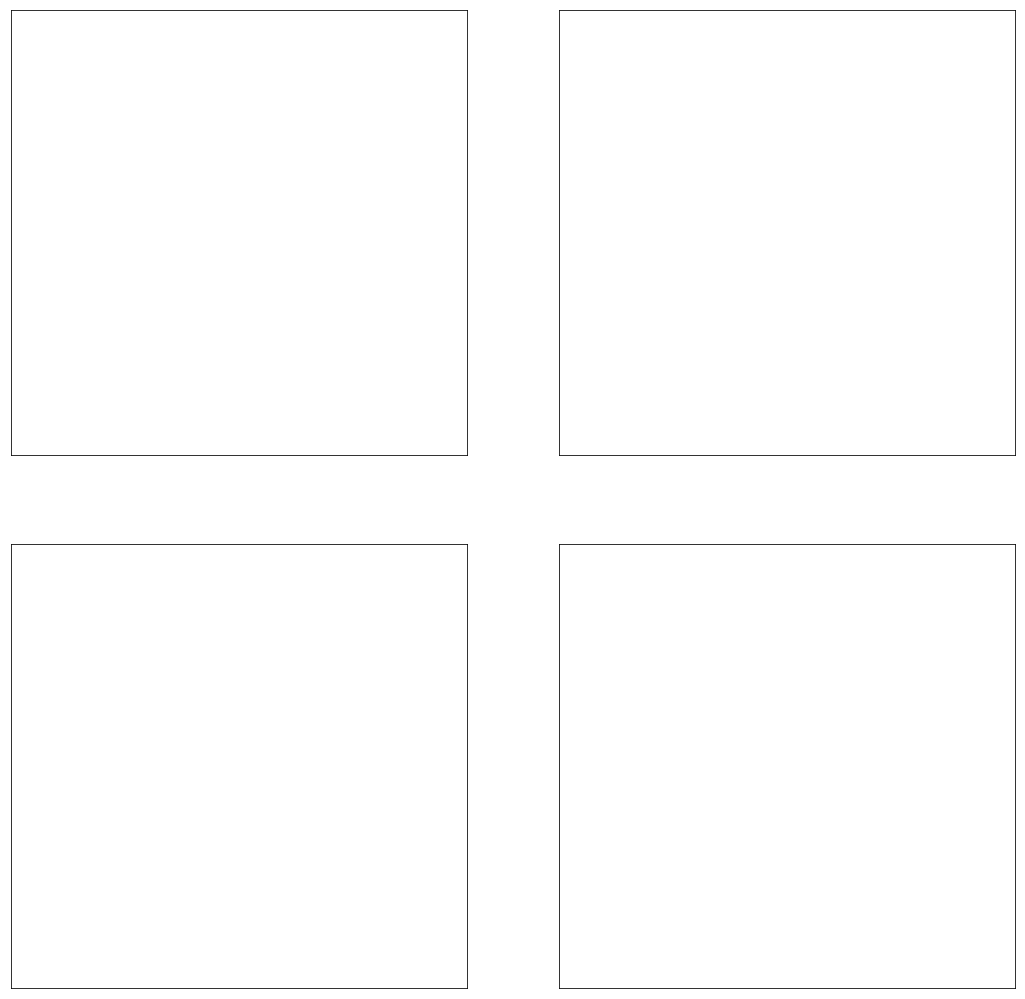

In [33]:
# display sample hog features

fig, ax = plt.subplots(2, 2, figsize=(18, 18),subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(turbine_images[0], cmap='gray')
ax[0].set_title('turbine image')
ax[1].imshow(turbine_hog_features[0]['hog_vis'])
ax[1].set_title('turbine HOG features');
ax[2].imshow(not_turbine_images[0], cmap='gray')
ax[2].set_title('not turbine image')
ax[3].imshow(not_turbine_hog_features[0]['hog_vis'])
ax[4].set_title('not turbine HOG features')
